# Analytical advection


While [Lagrangian Ocean Analysis](https://www.sciencedirect.com/science/article/pii/S1463500317301853) has been around since at least the 1980s, the [Blanke and Raynaud (1997)](https://journals.ametsoc.org/doi/full/10.1175/1520-0485%281997%29027%3C1038%3AKOTPEU%3E2.0.CO%3B2) paper has really spurred the use of Lagrangian particles for large-scale simulations. In their 1997 paper, Blanke and Raynaud introduce the so-called _Analytical Advection_ scheme for pathway integration. This scheme has been the base for the [Ariane](https://ariane-code.cnrs.fr/whatsariane.html) and [TRACMASS](http://www.tracmass.org/) tools. We have also implemented it in Parcels, particularly to facilitate comparison with for example the Runge-Kutta integration scheme.

In this tutorial, we will briefly explain what the scheme is and how it can be used in Parcels. For more information, see for example [Döös et al (2017)](https://www.geosci-model-dev.net/10/1733/2017/).


Note that the Analytical scheme works with a few limitations:

1. The velocity field should be defined on a C-grid (see also the [Parcels NEMO tutorial](https://docs.oceanparcels.org/en/latest/examples/tutorial_nemo_3D.html)).

And specifically for the implementation in Parcels 

2. For time-varying fields, only the 'intermediate timesteps' scheme ([section 2.3 of Döös et al 2017](https://www.geosci-model-dev.net/10/1733/2017/gmd-10-1733-2017.pdf)) is implemented. While there is also a way to also analytically solve the time-evolving fields ([section 2.4 of Döös et al 2017](https://www.geosci-model-dev.net/10/1733/2017/gmd-10-1733-2017.pdf)), this is not yet implemented in Parcels.

We welcome contributions to the further development of this algorithm and in particular the analytical time-varying case. See [here](https://github.com/OceanParcels/parcels/blob/master/parcels/application_kernels/advection.py) for the code of the `AdvectionAnalytical` kernel.


Below, we will show how this `AdvectionAnalytical` kernel performs on one idealised time-constant flow and two idealised time-varying flows: a radial rotation, the time-varying double-gyre as implemented in e.g. [Froyland and Padberg (2009)](https://www.sciencedirect.com/science/article/abs/pii/S0167278909000803) and the Bickley Jet as implemented in e.g. [Hadjighasem et al (2017)](https://aip.scitation.org/doi/10.1063/1.4982720).

First import the relevant modules.


In [1]:
from datetime import timedelta as delta

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

import parcels

## Radial rotation example

As in [Figure 4a of Lange and Van Sebille (2017)](https://doi.org/10.5194/gmd-10-4175-2017), we define a circular flow with period 24 hours, on a C-grid


In [2]:
def radialrotation_fieldset(xdim=201, ydim=201):
    # Coordinates of the test fieldset (on C-grid in m)
    a = b = 20000  # domain size
    lon = np.linspace(-a / 2, a / 2, xdim, dtype=np.float32)
    lat = np.linspace(-b / 2, b / 2, ydim, dtype=np.float32)
    dx, dy = lon[2] - lon[1], lat[2] - lat[1]

    # Define arrays R (radius), U (zonal velocity) and V (meridional velocity)
    U = np.zeros((lat.size, lon.size), dtype=np.float32)
    V = np.zeros((lat.size, lon.size), dtype=np.float32)
    R = np.zeros((lat.size, lon.size), dtype=np.float32)

    def calc_r_phi(ln, lt):
        return np.sqrt(ln**2 + lt**2), np.arctan2(ln, lt)

    omega = 2 * np.pi / delta(days=1).total_seconds()
    for i in range(lon.size):
        for j in range(lat.size):
            r, phi = calc_r_phi(lon[i], lat[j])
            R[j, i] = r
            r, phi = calc_r_phi(lon[i] - dx / 2, lat[j])
            V[j, i] = -omega * r * np.sin(phi)
            r, phi = calc_r_phi(lon[i], lat[j] - dy / 2)
            U[j, i] = omega * r * np.cos(phi)

    data = {"U": U, "V": V, "R": R}
    dimensions = {"lon": lon, "lat": lat}
    fieldset = parcels.FieldSet.from_data(data, dimensions, mesh="flat")
    fieldset.U.interp_method = "cgrid_velocity"
    fieldset.V.interp_method = "cgrid_velocity"
    return fieldset


fieldsetRR = radialrotation_fieldset()

Now simulate a set of particles on this fieldset, using the `AdvectionAnalytical` kernel. Keep track of how the radius of the Particle trajectory changes during the run.


In [3]:
def UpdateR(particle, fieldset, time):
    if time == 0:
        particle.radius_start = fieldset.R[
            time, particle.depth, particle.lat, particle.lon
        ]
    particle.radius = fieldset.R[time, particle.depth, particle.lat, particle.lon]


MyParticle = parcels.JITParticle.add_variables(
    [
        parcels.Variable("radius", dtype=np.float32, initial=0.0),
        parcels.Variable("radius_start", dtype=np.float32, initial=0.0),
    ]
)


pset = parcels.ParticleSet(fieldsetRR, pclass=MyParticle, lon=0, lat=4e3, time=0)

output = pset.ParticleFile(name="radialAnalytical.zarr", outputdt=delta(hours=1))

pset.execute(
    [UpdateR, parcels.AdvectionAnalytical],
    runtime=delta(hours=25),
    dt=output.outputdt,  # needs to be the same as outputdt for Analytical Advection
    output_file=output,
)

INFO: Output files are stored in radialAnalytical.zarr.
100%|██████████| 90000.0/90000.0 [00:01<00:00, 70146.02it/s]


Now plot the trajectory and calculate how much the radius has changed during the run.


Particle radius at start of run 4000.0
Particle radius at end of run 3999.969970703125
Change in Particle radius -0.030029296875


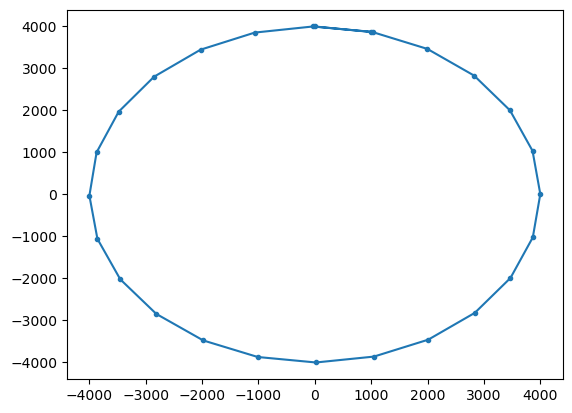

In [4]:
ds = xr.open_zarr("radialAnalytical.zarr")
plt.plot(ds.lon.T, ds.lat.T, ".-")

print(f"Particle radius at start of run {pset.radius_start[0]}")
print(f"Particle radius at end of run {pset.radius[0]}")
print(f"Change in Particle radius {pset.radius[0] - pset.radius_start[0]}")

## Double-gyre example

Define a double gyre fieldset that varies in time


In [5]:
def doublegyre_fieldset(times, xdim=51, ydim=51):
    """Implemented following Froyland and Padberg (2009)
    10.1016/j.physd.2009.03.002"""
    A = 0.25
    delta = 0.25
    omega = 2 * np.pi

    a, b = 2, 1  # domain size
    lon = np.linspace(0, a, xdim, dtype=np.float32)
    lat = np.linspace(0, b, ydim, dtype=np.float32)
    dx, dy = lon[2] - lon[1], lat[2] - lat[1]

    U = np.zeros((times.size, lat.size, lon.size), dtype=np.float32)
    V = np.zeros((times.size, lat.size, lon.size), dtype=np.float32)

    for i in range(lon.size):
        for j in range(lat.size):
            x1 = lon[i] - dx / 2
            x2 = lat[j] - dy / 2
            for t in range(len(times)):
                time = times[t]
                f = (
                    delta * np.sin(omega * time) * x1**2
                    + (1 - 2 * delta * np.sin(omega * time)) * x1
                )
                U[t, j, i] = -np.pi * A * np.sin(np.pi * f) * np.cos(np.pi * x2)
                V[t, j, i] = (
                    np.pi
                    * A
                    * np.cos(np.pi * f)
                    * np.sin(np.pi * x2)
                    * (
                        2 * delta * np.sin(omega * time) * x1
                        + 1
                        - 2 * delta * np.sin(omega * time)
                    )
                )

    data = {"U": U, "V": V}
    dimensions = {"lon": lon, "lat": lat, "time": times}
    allow_time_extrapolation = True if len(times) == 1 else False
    fieldset = parcels.FieldSet.from_data(
        data, dimensions, mesh="flat", allow_time_extrapolation=allow_time_extrapolation
    )
    fieldset.U.interp_method = "cgrid_velocity"
    fieldset.V.interp_method = "cgrid_velocity"
    return fieldset


fieldsetDG = doublegyre_fieldset(times=np.arange(0, 3.1, 0.1))

Now simulate a set of particles on this fieldset, using the `AdvectionAnalytical` kernel


In [6]:
X, Y = np.meshgrid(np.arange(0.15, 1.85, 0.1), np.arange(0.15, 0.85, 0.1))

psetAA = parcels.ParticleSet(fieldsetDG, pclass=parcels.JITParticle, lon=X, lat=Y)

output = psetAA.ParticleFile(name="doublegyreAA.zarr", outputdt=0.1)

psetAA.execute(
    parcels.AdvectionAnalytical,
    dt=output.outputdt,  # needs to be the same as outputdt for Analytical Advection
    runtime=3,
    output_file=output,
)

INFO: Output files are stored in doublegyreAA.zarr.
100%|██████████| 3.0/3.0 [00:01<00:00,  2.89it/s]                


And then show the particle trajectories in an animation


In [7]:
%%capture

ds = xr.open_zarr("doublegyreAA.zarr")

fig = plt.figure(figsize=(7, 5), constrained_layout=True)
ax = fig.add_subplot()

ax.set_ylabel("Meridional distance [m]")
ax.set_xlabel("Zonal distance [m]")
ax.set_xlim(0, 2)
ax.set_ylim(0, 1)

timerange = np.unique(ds["time"].values[np.isfinite(ds["time"])])

# Indices of the data where time = 0
time_id = np.where(ds["time"] == timerange[0])

sc = ax.scatter(ds["lon"].values[time_id], ds["lat"].values[time_id], c="b")

t = str(timerange[0].astype("timedelta64[ms]"))
title = ax.set_title(f"Particles at t = {t}")


def animate(i):
    t = str(timerange[i].astype("timedelta64[ms]"))
    title.set_text(f"Particles at t = {t}")

    time_id = np.where(ds["time"] == timerange[i])
    sc.set_offsets(np.c_[ds["lon"].values[time_id], ds["lat"].values[time_id]])


anim = FuncAnimation(fig, animate, frames=len(timerange), interval=100)

In [8]:
HTML(anim.to_jshtml())

Now, we can also compute these trajectories with the `AdvectionRK4` kernel


In [9]:
psetRK4 = parcels.ParticleSet(fieldsetDG, pclass=parcels.JITParticle, lon=X, lat=Y)
psetRK4.execute(parcels.AdvectionRK4, dt=0.01, runtime=3)

100%|██████████| 3.0/3.0 [00:00<00:00, 167.94it/s]


And we can then compare the final locations of the particles from the `AdvectionRK4` and `AdvectionAnalytical` simulations


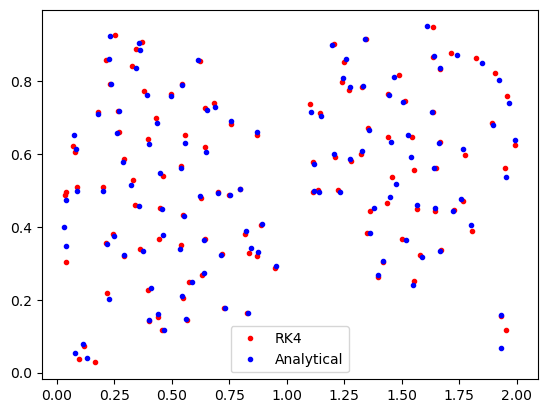

In [10]:
plt.plot(psetRK4.lon, psetRK4.lat, "r.", label="RK4")
plt.plot(psetAA.lon, psetAA.lat, "b.", label="Analytical")
plt.legend()
plt.show()

The final locations are similar, but not exactly the same. Because everything else is the same, the difference has to be due to the different kernels. Which one is more correct, however, can't be determined from this analysis alone.


## Bickley Jet example

Let's as a second example, do a similar analysis for a Bickley Jet, as detailed in e.g. [Hadjighasem et al (2017)](https://aip.scitation.org/doi/10.1063/1.4982720).


In [11]:
def bickleyjet_fieldset(times, xdim=51, ydim=51):
    """Bickley Jet Field as implemented in Hadjighasem et al 2017,
    10.1063/1.4982720"""
    U0 = 0.06266
    L = 1770.0
    r0 = 6371.0
    k1 = 2 * 1 / r0
    k2 = 2 * 2 / r0
    k3 = 2 * 3 / r0
    eps1 = 0.075
    eps2 = 0.4
    eps3 = 0.3
    c3 = 0.461 * U0
    c2 = 0.205 * U0
    c1 = c3 + ((np.sqrt(5) - 1) / 2.0) * (k2 / k1) * (c2 - c3)

    a, b = np.pi * r0, 7000.0  # domain size
    lon = np.linspace(0, a, xdim, dtype=np.float32)
    lat = np.linspace(-b / 2, b / 2, ydim, dtype=np.float32)
    dx, dy = lon[2] - lon[1], lat[2] - lat[1]

    U = np.zeros((times.size, lat.size, lon.size), dtype=np.float32)
    V = np.zeros((times.size, lat.size, lon.size), dtype=np.float32)
    P = np.zeros((times.size, lat.size, lon.size), dtype=np.float32)

    for i in range(lon.size):
        for j in range(lat.size):
            x1 = lon[i] - dx / 2
            x2 = lat[j] - dy / 2
            for t in range(len(times)):
                time = times[t]

                f1 = eps1 * np.exp(-1j * k1 * c1 * time)
                f2 = eps2 * np.exp(-1j * k2 * c2 * time)
                f3 = eps3 * np.exp(-1j * k3 * c3 * time)
                F1 = f1 * np.exp(1j * k1 * x1)
                F2 = f2 * np.exp(1j * k2 * x1)
                F3 = f3 * np.exp(1j * k3 * x1)
                G = np.real(np.sum([F1, F2, F3]))
                G_x = np.real(np.sum([1j * k1 * F1, 1j * k2 * F2, 1j * k3 * F3]))
                U[t, j, i] = (
                    U0 / (np.cosh(x2 / L) ** 2)
                    + 2 * U0 * np.sinh(x2 / L) / (np.cosh(x2 / L) ** 3) * G
                )
                V[t, j, i] = U0 * L * (1.0 / np.cosh(x2 / L)) ** 2 * G_x

    data = {"U": U, "V": V, "P": P}
    dimensions = {"lon": lon, "lat": lat, "time": times}
    allow_time_extrapolation = True if len(times) == 1 else False
    fieldset = parcels.FieldSet.from_data(
        data, dimensions, mesh="flat", allow_time_extrapolation=allow_time_extrapolation
    )
    fieldset.U.interp_method = "cgrid_velocity"
    fieldset.V.interp_method = "cgrid_velocity"
    return fieldset


fieldsetBJ = bickleyjet_fieldset(times=np.arange(0, 1.1, 0.1) * 86400)

Add a zonal halo for periodic boundary conditions in the zonal direction


In [12]:
fieldsetBJ.add_constant("halo_west", fieldsetBJ.U.grid.lon[0])
fieldsetBJ.add_constant("halo_east", fieldsetBJ.U.grid.lon[-1])
fieldsetBJ.add_periodic_halo(zonal=True)


def ZonalBC(particle, fieldset, time):
    if particle.lon < fieldset.halo_west:
        particle_dlon += fieldset.halo_east - fieldset.halo_west
    elif particle.lon > fieldset.halo_east:
        particle_dlon -= fieldset.halo_east - fieldset.halo_west

And simulate a set of particles on this fieldset, using the `AdvectionAnalytical` kernel


In [13]:
X, Y = np.meshgrid(np.arange(0, 19900, 100), np.arange(-100, 100, 100))

psetAA = parcels.ParticleSet(
    fieldsetBJ, pclass=parcels.JITParticle, lon=X, lat=Y, time=0
)

output = psetAA.ParticleFile(name="bickleyjetAA.zarr", outputdt=delta(hours=1))

psetAA.execute(
    [parcels.AdvectionAnalytical, ZonalBC],
    dt=output.outputdt,  # needs to be the same as outputdt for Analytical Advection
    runtime=delta(days=1),
    output_file=output,
)

INFO: Output files are stored in bickleyjetAA.zarr.
100%|██████████| 86400.0/86400.0 [00:12<00:00, 6762.80it/s]


And then show the particle trajectories in an animation


In [14]:
%%capture

ds = xr.open_zarr("bickleyjetAA.zarr")

fig = plt.figure(figsize=(7, 5), constrained_layout=True)
ax = fig.add_subplot()

ax.set_ylabel("Meridional distance [m]")
ax.set_xlabel("Zonal distance [m]")
ax.set_xlim(0, 2e4)
ax.set_ylim(-2500, 2500)

timerange = np.unique(ds["time"].values[np.isfinite(ds["time"])])

# Indices of the data where time = 0
time_id = np.where(ds["time"] == timerange[0])

sc = ax.scatter(ds["lon"].values[time_id], ds["lat"].values[time_id], c="b")

t = str(timerange[0].astype("timedelta64[h]"))
title = ax.set_title(f"Particles at t = {t}")


def animate(i):
    t = str(timerange[i].astype("timedelta64[h]"))
    title.set_text(f"Particles at t = {t}")

    time_id = np.where(ds["time"] == timerange[i])
    sc.set_offsets(np.c_[ds["lon"].values[time_id], ds["lat"].values[time_id]])


anim = FuncAnimation(fig, animate, frames=len(timerange), interval=100)

In [15]:
HTML(anim.to_jshtml())

Like with the double gyre above, we can also compute these trajectories with the `AdvectionRK4` kernel


In [16]:
psetRK4 = parcels.ParticleSet(fieldsetBJ, pclass=parcels.JITParticle, lon=X, lat=Y)

psetRK4.execute(
    [parcels.AdvectionRK4, ZonalBC], dt=delta(minutes=5), runtime=delta(days=1)
)

100%|██████████| 86400.0/86400.0 [00:00<00:00, 1704047.56it/s]


And finally, we can again compare the end locations from the `AdvectionRK4` and `AdvectionAnalytical` simulations


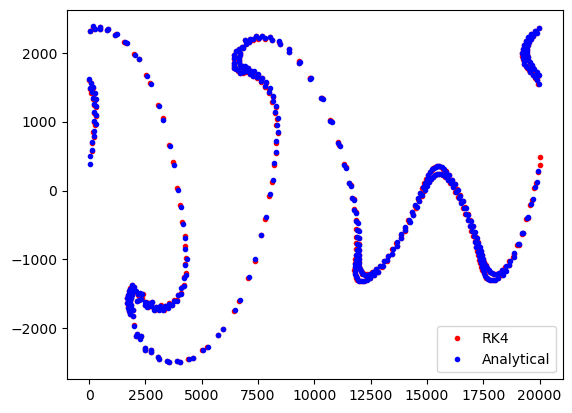

In [17]:
plt.plot(psetRK4.lon, psetRK4.lat, "r.", label="RK4")
plt.plot(psetAA.lon, psetAA.lat, "b.", label="Analytical")
plt.legend()
plt.show()